In [1]:
from natsort import natsorted
import os
import re
from glob import glob
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import networkx as nx

import sklearn.neighbors

import imageio
import cv2
import skimage
from skimage import img_as_float32, img_as_ubyte, img_as_uint
from skimage.feature import canny
from skimage.color import rgb2gray, rgb2hsv, gray2rgb, rgba2rgb
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)
# caching with sane defaults
from cachier import cachier
cachier = partial(cachier, pickle_reload=False, cache_dir='data/cache')
############################## Stuff for loading and rescaling the puzzle pieces nicely ################################

In [2]:
SIZE = (768, 1024)

DATA_PATH_PAIRS = list(zip(
    natsorted(glob(f'./datasets/puzzle_corners_{SIZE[1]}x{SIZE[0]}/images-{SIZE[1]}x{SIZE[0]}/*.png')),
    natsorted(glob(f'./datasets/puzzle_corners_{SIZE[1]}x{SIZE[0]}/masks-{SIZE[1]}x{SIZE[0]}/*.png')),
))
DATA_IMGS = np.array([img_as_float32(imageio.imread(img_path)) for img_path, _ in tqdm(DATA_PATH_PAIRS, 'Loading Images')])
DATA_MSKS = np.array([img_as_float32(imageio.imread(msk_path)) for _, msk_path in tqdm(DATA_PATH_PAIRS, 'Loading Masks')])

assert DATA_IMGS.shape == (48, SIZE[0], SIZE[1], 3)
assert DATA_MSKS.shape == (48, SIZE[0], SIZE[1])

with open(f'./datasets/puzzle_corners_{SIZE[1]}x{SIZE[0]}/corners.json', mode='r') as f:
    DATA_CORNER_NAMES, DATA_CORNERS = json.load(f)
    DATA_CORNERS = np.array(DATA_CORNERS)

assert len(DATA_CORNER_NAMES) == len(DATA_CORNERS) == len(DATA_IMGS) == len(DATA_MSKS) == len(DATA_PATH_PAIRS)

SCALE = 0.25

MATCH_IMGS = [cv2.resize(img, None, fx=SCALE, fy=SCALE) for img in tqdm(DATA_IMGS, 'Resizing Images')]
MATCH_MSKS = [cv2.resize(img, None, fx=SCALE, fy=SCALE) for img in tqdm(DATA_MSKS, 'Resizing Masks')]
MATCH_CORNERS = DATA_CORNERS 

print('\n', DATA_IMGS[0].shape, '->', MATCH_IMGS[0].shape)


Loading Images:   0%|          | 0/48 [00:00<?, ?it/s]C:\Users\joshu\AppData\Local\Temp\ipykernel_11584\261244800.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  DATA_IMGS = np.array([img_as_float32(imageio.imread(img_path)) for img_path, _ in tqdm(DATA_PATH_PAIRS, 'Loading Images')])
Loading Masks:   0%|          | 0/48 [00:00<?, ?it/s]C:\Users\joshu\AppData\Local\Temp\ipykernel_11584\261244800.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  DATA_MSKS = np.array([img_as_float32(imageio.imread(msk_path)) for _, msk_path in tqdm(DATA_PATH_PAIRS, 'Loading Masks')])
Resizing Mas


 (768, 1024, 3) -> (192, 256, 3)


In [3]:
# Create our canvas with the necessary size
canvas = np.zeros((800,700,3))

In [4]:
################################################ Define our three classes #############################################
class Edge:
    def __init__(self, point1, point2, contour, parent_piece):
        self.parent_piece = parent_piece # Puzzle piece the edge belongs to
        # first and last points
        self.point1 = point1  # Points should be anti-clockwise
        self.point2 = point2 
        self.connected_edge = None
        self.is_flat = None

    def info(self):
        print("Point 1: ", self.point1)
        print("Point 2: ", self.point2)


In [12]:
class Piece:
	def __init__(self, image, idx):
		self.piece_type = None
		self.inserted = False
		# Keep track of where the pieces corner's are. Used to construct the edge variables
		self.corners = None  # randomly ordered corners
		self.top_left = None
		self.top_right = None
		self.bottom_left = None
		self.bottom_right = None
		# Edges are anti-clockwise
		self.top_edge = None
		self.left_edge = None
		self.bottom_edge = None
		self.right_edge = None
		# Edge list used for BFS generator and in inserting function to search for the necessary edge
		self.edge_list = None
		# We hold the actual image of the piece so we can insert it onto the canvas
		self.image = image
		self.idx = idx
		# We also hold the mask and transform it with the image so we always know where our piece is in the image
		self.mask = None
		# Holds image after mapping
		self.dst = None
		# ~=~=~=~=~=~=~=~=~=~=~=~=~=~ #
		self.extract_features()
		self.classify_pixels()
		self.find_corners()
		self.find_edges()

	def return_edge(self): # generator which can be used to loop through edges in the BFS
		while True:
			for edge in self.edge_list:
				yield(edge)

	def display_im(self): # Displays puzzle piece image
		plt.imshow(self.image)
		plt.show()
		plt.close()

	def print_corners(self): # Prints the coordinates of the puzzle piece's corners
		print("Top left: ", self.top_left)
		print("top right: ", self.top_right)
		print("bottom right: ", self.bottom_right)
		print("bottom left: ", self.bottom_left)

	def print_edges(self): # Prints the information of the puzzle piece's edges
		print("Top Edge")
		self.top_edge.info()
		print("Left Edge")
		self.left_edge.info()
		print("Bottom Edge")
		self.bottom_edge.info()
		print("Right Edge")
		self.right_edge.info()

	def update_edges(self, transform):
		# TODO: Update the corner and edge information of the puzzle piece
		#1.1.3
		for c in self.corners:
			c = np.append(c[::-1],1) #flips co-cords and appends 1
			c = np.dot(c,np.transpose(transform)) #first transpose transform then right multiply by transform
			c = c[::-1]

		for e in self.edge_list:
			if e == None:
				continue
			p1,p2 = e.point1, e.point2
			print('Before',p1,p2)
			p1 = np.append(p1[::-1],1) 
			p1 = np.dot(p1,np.transpose(transform)) 
			p1 = p1[::-1]
   
			p2 = np.append(p2[::-1],1) #flips co-cords and appends 1
			p2 = np.dot(p2,np.transpose(transform)) #first transpose transform then right multiply by transform
			p2 = p2[::-1]
   
   
			print('\nAfter',p1,p2,'\n')
			
   
			e.point1,e.point2 = p1,p2

	def extract_features(self):
		# Function which will extract all the necessary features to classify pixels
		# into background and foreground
		# Should take no input and use self.image. Returns the features image (Not for Lab 7)
		return

	def classify_pixels(self):
		# Uses the feature image from self.extract_features to classify pixels
		# into foreground and background pixels. Returns the inferred mask
		# and should update self.mask with this update as we need it in future (Not for Lab 7)
		self.mask = MATCH_MSKS[self.idx]

	def find_corners(self):
		# Finds the corners of the puzzle piece (should use self.mask). Needs to update
		# the corner info of the object (eg: self.top_left). (Not for Lab 7)
		corners = MATCH_CORNERS[self.idx] * self.mask.shape[::-1]

		# sort in anti-clockwise direction
		angle_around_center = np.arctan2(*(corners - corners.mean(axis=0)).T)
		self.corners = corners[np.argsort(angle_around_center), :]

		self.top_left = self.corners[0][::-1] 
		self.top_right = self.corners[3][::-1] 
		self.bottom_right = self.corners[2][::-1] 
		self.bottom_left = self.corners[1][::-1] 
		
	def find_edges(self):
		# Finds the contour information from self.mask. Should then create the
		# edge objects for this piece. Also needs to update self.edge_list 
		# (ending in None) and self.piece_type based on number of non-straight edges (not for Lab 7)
		self.top_edge = Edge(self.top_right, self.top_left, None, self) #[0][0], [0][-1]
		self.left_edge = Edge(self.top_left, self.bottom_left, None, self) #1
		self.bottom_edge = Edge(self.bottom_left, self.bottom_right, None, self) #2
		self.right_edge = Edge(self.bottom_right, self.top_right, None, self) #3
		self.edge_list = [self.top_edge, self.left_edge, self.bottom_edge, self.right_edge, None]

	def insert(self): # Inserts the piece into the canvas using an affine transformation
		# TODO: Implement this function
		print("Inserting piece: ", self.idx)
		#1.1
		num_connected= 0
		for e in self.edge_list:
			if e != None and e.connected_edge != None and e.connected_edge.parent_piece != None and e.connected_edge.parent_piece.inserted:
				num_connected += 1
		
		try:
			p_type = ['corner','edge','interior']
			self.piece_type = p_type[num_connected]
		except IndexError:
			raise IndexError('The number of occurrences is greater than 2')

		#1.2
		pts_src = []
		pts_dst = []
		if self.piece_type == 'corner':
			flat_edges = []
			
			for e in self.edge_list:
				if e != None and e.is_flat:
					flat_edges.append(e)

     
			pts_src.append(flat_edges[0].point2[::-1]) # ensuring row-col coordinates
			pts_dst.append(np.array([0,800]).astype(np.float32)) #bottom left corner of canvas
   
			pts_src.append(flat_edges[0].point1[::-1])
			h = np.abs(flat_edges[0].point1[0] - flat_edges[0].point2[0])# Getting the height of the puzzle piece
			pts_dst.append(np.array([0,800- h]).astype(np.float32))
   
			pts_src.append(flat_edges[1].point2[::-1])
			w = np.abs(flat_edges[1].point1[1] - flat_edges[1].point2[1])# Getting the width of the puzzle piece
			pts_dst.append(np.array([0 + w,800]).astype(np.float32))

		elif self.piece_type == 'interior':
			
			for e in self.edge_list:
				if e != None and e.connected_edge != None and e.connected_edge.parent_piece.inserted:
					if not np.isin(e.point1,pts_src).all():
						pts_src.append(np.array(e.point1[::-1]).astype(np.float32))
     
					if not np.isin(e.point2,pts_src).all():
						pts_src.append(np.array(e.point2[::-1]).astype(np.float32))
      
					if not np.isin(e.connected_edge.point1,pts_dst).all():
						pts_dst.append(np.array(e.connected_edge.point1[::-1]).astype(np.float32))
      
					if not np.isin(e.connected_edge.point2,pts_dst).all():
						pts_dst.append(np.array(e.connected_edge.point2[::-1]).astype(np.float32))
      
		elif self.piece_type == 'edge':
		
			for i,e in enumerate(self.edge_list):
				if e != None and e.connected_edge != None and e.connected_edge.parent_piece.inserted:
					third_edge = e #The edge that is already connected to an edge in the canvas
					third_edge_index = i
     
					if not np.isin(e.point1,pts_src).all():
						pts_src.append(e.point1[::-1].astype(np.float32))
     
					if not np.isin(e.point2,pts_src).all():
						pts_src.append(e.point2[::-1].astype(np.float32))
      
					if not np.isin(e.connected_edge.point1,pts_dst).all():
						pts_dst.append(e.connected_edge.point1[::-1].astype(np.float32))
      
					if not np.isin(e.connected_edge.point2,pts_dst).all():
						pts_dst.append(e.connected_edge.point2[::-1].astype(np.float32))
    
      
					orig_norm = np.linalg.norm(np.array(e.point1[::-1].astype(np.float32))-np.array(e.point2[::-1].astype(np.float32)),2)
					canvas_norm = np.linalg.norm(np.array(e.connected_edge.point1[::-1].astype(np.float32))-np.array(e.connected_edge.point2[::-1].astype(np.float32)),2)
					ratio = orig_norm/canvas_norm
					print(ratio)
     
					if (pts_dst[0][0] - pts_dst[1][0]) > (pts_dst[0][1] - pts_dst[1][1]):
						#Finding next edge using index not looping through
						# if third_edge_index == 3:
						# 	fourth_edge = self.edge_list[0]
						# else:
						# 	fourth_edge = self.edge_list[third_edge_index + 1]
						for i in range(4):
							if self.edge_list[i] != None and self.edge_list[i] == e:
								if i == 3:
									fourth_edge = self.edge_list[0]
								else:
									fourth_edge = self.edge_list[i+1]
								break
									

						pts_src.append(fourth_edge.point2[::-1].astype(np.float32))
						edge_norm = np.linalg.norm(np.array(fourth_edge.point1[::-1].astype(np.float32))-np.array(fourth_edge.point2[::-1].astype(np.float32)))

						pts_dst.append([pts_dst[1][0]+int(ratio*edge_norm),pts_dst[1][1]])

					else:
						for i in range(3,-1,-1):
							if self.edge_list[i] != None and self.edge_list[i] == e:
								if i == 0:
									fifth_edge = self.edge_list[3]
								else:
									fifth_edge = self.edge_list[i-1]
								break

						pts_src.append(fifth_edge.point1[::-1].astype(np.float32))
						fifth_edge_norm = np.linalg.norm(np.array(fifth_edge.point1[::-1].astype(np.float32))-np.array(fifth_edge.point2[::-1].astype(np.float32)))
      
						pts_dst.append([pts_dst[1][0]+int(ratio*fifth_edge_norm),pts_dst[1][1]])
					
		else:
			print('Did not account for this piece')

		#Same instructions to add a piece to the canvas, regardless of type
  
		pts_src,pts_dst = np.array(pts_src).astype(np.float32),np.array(pts_dst).astype(np.float32)
		print(pts_src)
		print(pts_dst)
  
		M = cv2.getAffineTransform(pts_src,pts_dst)

		self.dst = cv2.warpAffine(self.image,M,(700,800)) # output_dimensions here are the dimensionality (column-row dimensionality) of the canvas
		self.mask = cv2.warpAffine(self.mask,M,(700,800))
  
		self.update_edges(M)
  
		# print(self.dst)

		for c in range(3):
			canvas[:, :, c] = self.mask*self.dst[:, :, c] + (1-self.mask)*canvas[:, :, c]#not sure about this line

		plt.imshow(canvas)
		plt.show()
		plt.close()


In [7]:
class Puzzle(object):
    def __init__(self, imgs):
        # generate all piece information
        self.pieces = [
            Piece(img, idx)
            for idx, img in tqdm(enumerate(imgs), 'Generating Pieces')
        ]
        self._fill_connections()

    def _fill_connections(self):
        connections = np.ones((48,4,2))*-1
        connections[0,2] = [26,1]
        connections[0,3] = [5,3]
        connections[1,0] = [14,3]
        connections[1,2] = [29,3]
        connections[1,3] = [22,2]
        connections[2,0] = [19,0]
        connections[2,1] = [12,1]
        connections[2,2] = [7,2]
        connections[2,3] = [16,0]
        connections[3,0] = [44,0]
        connections[3,3] = [6,1]
        connections[4,1] = [5,1]
        connections[4,2] = [41,0]
        connections[4,3] = [34,1]
        connections[5,0] = [7,0]
        connections[5,1] = [4,1]
        connections[5,3] = [0,3]
        connections[6,0] = [37,0]
        connections[6,1] = [3,3]
        connections[6,3] = [32,1]
        connections[7,0] = [5,0]
        connections[7,1] = [26,0]
        connections[7,2] = [2,2]
        connections[7,3] = [41,1]
        connections[8,0] = [15,0]
        connections[8,1] = [46,1]
        connections[9,0] = [25,2]
        connections[9,1] = [47,2]
        connections[9,2] = [28,0]
        connections[9,3] = [12,3]
        connections[10,0] = [33,2]
        connections[10,2] = [31,0]
        connections[10,3] = [11,1]
        connections[11,0] = [19,2]
        connections[11,1] = [10,3]
        connections[11,2] = [23,1]
        connections[11,3] = [36,3]
        connections[12,0] = [41,2]
        connections[12,1] = [2,1]
        connections[12,2] = [35,1]
        connections[12,3] = [9,3]
        connections[13,0] = [27,1]
        connections[13,1] = [22,0]
        connections[13,2] = [25,0]
        connections[13,3] = [36,1]
        connections[14,0] = [30,1]
        connections[14,1] = [15,2]
        connections[14,3] = [1,0]
        connections[15,0] = [8,0]
        connections[15,2] = [14,1]
        connections[15,3] = [40,3]
        connections[16,0] = [2,3]
        connections[16,1] = [26,3]
        connections[16,3] = [33,0]
        connections[17,0] = [43,2]
        connections[17,1] = [37,1]
        connections[17,2] = [32,0]
        connections[17,3] = [20,3]
        connections[18,1] = [34,3]
        connections[18,2] = [38,2]
        connections[18,3] = [21,1]
        connections[19,0] = [2,0]
        connections[19,1] = [33,3]
        connections[19,2] = [11,0]
        connections[19,3] = [35,2]
        connections[20,0] = [39,0]
        connections[20,1] = [40,1]
        connections[20,2] = [27,3]
        connections[20,3] = [17,3]
        connections[21,1] = [18,3]
        connections[21,2] = [24,1]
        connections[22,0] = [13,1]
        connections[22,1] = [30,2]
        connections[22,2] = [1,3]
        connections[22,3] = [45,0]
        connections[23,0] = [43,1]
        connections[23,1] = [11,2]
        connections[23,2] = [31,3]
        connections[23,3] = [37,2]
        connections[24,1] = [21,2]
        connections[24,2] = [38,1]
        connections[24,3] = [42,1]
        connections[25,0] = [13,2]
        connections[25,1] = [45,3]
        connections[25,2] = [9,0]
        connections[25,3] = [35,0]
        connections[26,0] = [7,1]
        connections[26,1] = [0,2]
        connections[26,3] = [16,1]
        connections[27,0] = [30,3]
        connections[27,1] = [13,0]
        connections[27,2] = [43,3]
        connections[27,3] = [20,2]
        connections[28,0] = [9,2]
        connections[28,1] = [38,3]
        connections[28,2] = [34,2]
        connections[28,3] = [41,3]
        connections[29,1] = [42,3]
        connections[29,2] = [45,1]
        connections[29,3] = [1,2]
        connections[30,0] = [40,0]
        connections[30,1] = [14,0]
        connections[30,2] = [22,1]
        connections[30,3] = [27,0]
        connections[31,0] = [10,2]
        connections[31,2] = [44,2]
        connections[31,3] = [23,2]
        connections[32,0] = [17,2]
        connections[32,1] = [6,3]
        connections[32,3] = [39,1]
        connections[33,0] = [16,3]
        connections[33,2] = [10,0]
        connections[33,3] = [19,1]
        connections[34,1] = [4,3]
        connections[34,2] = [28,2]
        connections[34,3] = [18,1]
        connections[35,0] = [25,3]
        connections[35,1] = [12,2]
        connections[35,2] = [19,3]
        connections[35,3] = [36,2]
        connections[36,0] = [43,0]
        connections[36,1] = [13,3]
        connections[36,2] = [35,3]
        connections[36,3] = [11,3]
        connections[37,0] = [6,0]
        connections[37,1] = [17,1]
        connections[37,2] = [23,3]
        connections[37,3] = [44,1]
        connections[38,0] = [47,1]
        connections[38,1] = [24,2]
        connections[38,2] = [18,2]
        connections[38,3] = [28,1]
        connections[39,0] = [20,0]
        connections[39,1] = [32,3]
        connections[39,3] = [46,3]
        connections[40,0] = [30,0]
        connections[40,1] = [20,1]
        connections[40,2] = [46,2]
        connections[40,3] = [15,3]
        connections[41,0] = [4,2]
        connections[41,1] = [7,3]
        connections[41,2] = [12,0]
        connections[41,3] = [28,3]
        connections[42,1] = [24,3]
        connections[42,2] = [47,0]
        connections[42,3] = [29,1]
        connections[43,0] = [36,0]
        connections[43,1] = [23,0]
        connections[43,2] = [17,0]
        connections[43,3] = [27,2]
        connections[44,0] = [3,0]
        connections[44,1] = [37,3]
        connections[44,2] = [31,2]
        connections[45,0] = [22,3]
        connections[45,1] = [29,2]
        connections[45,2] = [47,3]
        connections[45,3] = [25,1]
        connections[46,1] = [8,1]
        connections[46,2] = [40,2]
        connections[46,3] = [39,3]
        connections[47,0] = [42,2]
        connections[47,1] = [38,0]
        connections[47,2] = [9,1]
        connections[47,3] = [45,2]
        connections = connections.astype(np.int16)
        for i in range(connections.shape[0]):
            for j in range(connections.shape[1]):
                if not list(connections[i,j]) == [-1,-1]:
                    self.pieces[i].edge_list[j].connected_edge=self.pieces[connections[i,j][0]].edge_list[connections[i,j][1]]
                else:
                    self.pieces[i].edge_list[j].is_flat = True


Generating Pieces: 48it [00:00, 16004.98it/s]


Inserting piece:  3
[[ 44.71467 138.79929]
 [ 46.08     38.87744]
 [163.84    140.84547]]
[[  0.      800.     ]
 [  0.      700.0781 ]
 [119.12533 800.     ]]
Before [ 38.19538307 164.5226593 ] [38.87744236 46.08000183]

After [697.36224099 118.4055476 ] [7.00078126e+02 1.30279574e-08] 

Before [38.87744236 46.08000183] [138.7992897   44.71466827]

After [7.00078126e+02 1.30279574e-08] [8.00000004e+02 5.21118366e-08] 

Before [138.7992897   44.71466827] [140.84547043 163.83999634]

After [8.00000004e+02 5.21118366e-08] [799.99999619 119.12532801] 

Before [140.84547043 163.83999634] [ 38.19538307 164.5226593 ]

After [799.99999619 119.12532801] [697.36224099 118.4055476 ] 



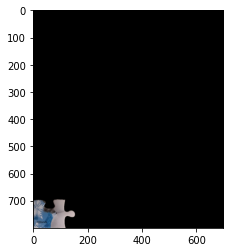

Inserting piece:  44
1.0068691
[[179.2       56.95204 ]
 [ 60.074665  62.408524]
 [ 64.512    164.03552 ]]
[[1.1840555e+02 6.9736224e+02]
 [1.3027957e-08 7.0007812e+02]
 [1.0200000e+02 7.0007812e+02]]
Before [ 56.95204353 179.19999695] [62.40852356 60.07466507]

After [697.36224365 118.40554992] [7.00078125e+02 1.30279574e-08] 

Before [62.40852356 60.07466507] [164.03552628  64.51200104]

After [7.00078125e+02 1.30279574e-08] [700.078125   102.00000366] 

Before [164.03552628  64.51200104] [158.57904053 184.66133118]

After [700.078125   102.00000366] [697.3389446  221.46830955] 

Before [158.57904053 184.66133118] [ 56.95204353 179.19999695]

After [697.3389446  221.46830955] [697.36224365 118.40554992] 



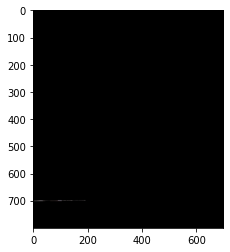

Inserting piece:  6
1.0067627
[[ 48.128    64.11368]
 [ 47.44533 167.44583]
 [169.30133  64.11368]]
[[119.12533 800.     ]
 [118.40555 697.36224]
 [239.40555 697.36224]]
Before [ 64.11367607 169.30133057] [64.11367607 48.12799835]

After [697.36224556 239.4055481 ] [800.00000191 119.12532806] 

Before [64.11367607 48.12799835] [167.4458313   47.44533157]

After [800.00000191 119.12532806] [697.36224365 118.4055481 ] 

Before [167.4458313   47.44533157] [167.4458313 168.6186676]

After [697.36224365 118.4055481 ] [594.72448407 238.68577191] 

Before [167.4458313 168.6186676] [ 64.11367607 169.30133057]

After [594.72448407 238.68577191] [697.36224556 239.4055481 ] 



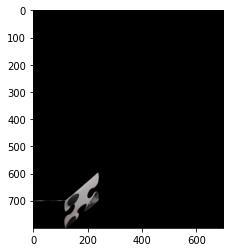

Inserting piece:  37
[[187.05066   66.50089 ]
 [ 65.194664  55.58792 ]
 [176.128    168.80994 ]
 [187.05066   66.50089 ]]
[[2.3940555e+02 6.9736224e+02]
 [1.1912533e+02 8.0000000e+02]
 [1.3027957e-08 7.0007812e+02]
 [1.0200000e+02 7.0007812e+02]]


error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\imgwarp.cpp:3399: error: (-215:Assertion failed) src.checkVector(2, CV_32F) == 3 && dst.checkVector(2, CV_32F) == 3 in function 'cv::getAffineTransform'


In [13]:
puzzle = Puzzle(MATCH_IMGS)
corner_piece = puzzle.pieces[3]

canvas = np.zeros((800,700,3))

# Start BFS by adding in the bottom left corner piece
queue = []
queue.append(corner_piece)
corner_piece.insert()
corner_piece.inserted = True
canvas = np.zeros((800,700,3))
# TODO: Rest of BFS
while queue:
	curr = queue.pop(0)

	for edge in curr.return_edge():
		if edge == None:
			break
		if edge.connected_edge:
			next_piece = edge.connected_edge.parent_piece
			if not next_piece.inserted:
				queue.append(next_piece)
				next_piece.insert()
				next_piece.inserted = True